In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import datatable as dt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import UQ_toolbox as uq
from PIL import Image
from skimage import io
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda:1")

True


In [4]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [5]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape, img_name = sample['image'], sample['shape'], sample['name']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape)),
                'name': img_name}

In [6]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape, img_name = sample['image'], sample['shape'], sample['name']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape,            
                'name': img_name}

In [7]:
# Load the models
model_paths = ['model_shape_0_augmented.pt', 'model_shape_1_augmented.pt', 'model_shape_2_augmented.pt', 'model_shape_3_augmented.pt', 'model_shape_4_augmented.pt']
models_list = []
path_to_models = './models/'
for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path_to_models + path))
    model.eval()  # Set the model to evaluation mode
    models_list.append(model)

In [8]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape, 'name':img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [9]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels, preds)

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels, preds, average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels, preds, average='binary')

def roc_auc(outputs, labels):
    probs = outputs
    return roc_auc_score(labels, probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels, preds)

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [10]:
def display_confusion_matrix(cm):
    # Define class names
    class_names = ['Round', 'Irregular']
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
def calculate_val_metrics(all_preds, all_labels):

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    display_confusion_matrix(cm)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    print('Accuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))

In [12]:
# Function to make predictions
def predict(models, image):
    image = image.to(device)
    predictions = [model(image).cpu().detach().numpy() for model in models]
    return predictions

In [13]:
def plot_tumor_predictions_with_percentages(data, shape_df):

    # Process and aggregate data for the bar plot
    tumor_data = {}
    
    for entry in data:
        img_name = entry['img_name']
        predicted_class = entry['predicted_class']
        # Extract patient (tumor) number and cut number from the image name
        tumor_id, cut_id_with_ext = img_name.split('/')[-1].split('_')[:2]
        cut_id = cut_id_with_ext.split('.')[0]  # Remove .png extension
        
        if tumor_id not in tumor_data:
            tumor_data[tumor_id] = []
        
        # Add predicted class (0 for round, 1 for irregular) to tumor's list
        tumor_data[tumor_id].append((int(cut_id), predicted_class))
    
    # Sort cuts by their axial number within each tumor
    for tumor_id in tumor_data:
        tumor_data[tumor_id].sort(key=lambda x: x[0])
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(8, 10))
    
    # For each tumor, create a row of colored bars based on the axial cut predictions
    y_positions = np.arange(len(tumor_data))
    
    for i, (tumor_id, cuts) in enumerate(sorted(tumor_data.items())):
     
        # Extract cut numbers and predicted classes
        cut_ids, predicted_classes = zip(*cuts)
        
        # Create a color map: red for 'Round' (class 0) and blue for 'Irregular' (class 1)
        colors = ['red' if pred == 0 else 'blue' for pred in predicted_classes]
        
        # Initialize variables to keep track of blocks of the same color
        current_color = colors[0]
        block_start = cut_ids[0]
        block_count = 1
        
        total_cuts = len(cuts)
        
        for j in range(1, total_cuts):
            if colors[j] == current_color:
                # Continue the current block
                block_count += 1
            else:
                # End the current block, plot it
                ax.barh(i, block_count, left=block_start, height=0.8, color=current_color)
                
                # Calculate the percentage for the block
                percentage = (block_count / total_cuts) * 100
                
                # Add the percentage as text in the middle of the block
                ax.text(block_start + block_count / 2, i, f'{percentage:.1f}%', va='center', ha='center', color='white')
                
                # Start a new block
                current_color = colors[j]
                block_start = cut_ids[j]
                block_count = 1
        
        # Plot the final block
        ax.barh(i, block_count, left=block_start, height=0.8, color=current_color)
        percentage = (block_count / total_cuts) * 100
        ax.text(block_start + block_count / 2, i, f'{percentage:.1f}%', va='center', ha='center', color='white')
        
        # Get the shape from the dataframe based on the tumor ID
        try:
            shape_label = shape_df.loc[shape_df['Record_ID'] == int(tumor_id), 'Shape.1'].values[0]
        except IndexError:
            shape_label = 'Unknown'  # Assign a default value if not found

        # Add the shape label as text at the end of the bar
        ax.text(max(cut_ids) + 1, i, shape_label, va='center')
    
    ax.set_xlabel('Axial Cuts')
    ax.set_ylabel('Tumors')
    ax.set_title('Tumor Axial Cut Predictions with Percentages and Shape Labels')
    ax.set_yticks(y_positions)
    ax.set_yticklabels(sorted(tumor_data.keys()))
    
    plt.tight_layout()
    plt.show()


In [14]:
def classify_tumors_by_contingent_blocks_with_sorting(data, shape_df, threshold=60):
    y_true = []
    y_pred = []
    
    # Process and aggregate data for each tumor
    tumor_data = {}
    
    for entry in data:
        img_name = entry['img_name']
        predicted_class = entry['predicted_class']
        
        # Extract patient (tumor) number and cut number from the image name
        tumor_id, cut_id_with_ext = img_name.split('/')[-1].split('_')[:2]
        cut_id = int(cut_id_with_ext.split('.')[0])  # Remove .png extension and convert to integer for sorting
        
        if tumor_id not in tumor_data:
            tumor_data[tumor_id] = []
        
        # Append both cut_id and predicted class to ensure sorting
        tumor_data[tumor_id].append((cut_id, predicted_class))
    
    # Classify each tumor based on the largest contiguous block of "Round" cuts
    for tumor_id, cuts in tumor_data.items():
        # Sort cuts by cut_id to ensure the correct sequence
        cuts_sorted = sorted(cuts, key=lambda x: x[0])  # Sort by cut_id
        
        # Extract only the predicted classes from sorted data
        predicted_classes_sorted = [pred_class for _, pred_class in cuts_sorted]
        
        #print(f"Processing tumor ID: {tumor_id}")
        
        # Find the true label from the shape_df dataframe ('Shape.1' column)
        try:
            shape_label = shape_df.loc[shape_df['Record_ID'] == int(tumor_id), 'Shape.1'].values[0]
            true_label = 0 if shape_label == 'Round' else 1  # Convert 'Round' to 0, 'Irregular' to 1
            #print(f"True label (from Shape.1): {shape_label}, Converted to: {true_label}")
        except IndexError:
            #print(f"Tumor ID {tumor_id} not found in shape_df!")
            continue  # Skip if tumor_id not found in shape_df
        
        # Calculate the largest contiguous block of "Round" (class 0) cuts
        max_round_block = 0
        current_round_block = 0
        total_cuts = len(predicted_classes_sorted)
        
        for pred_class in predicted_classes_sorted:
            if pred_class == 0:
                current_round_block += 1
            else:
                current_round_block = 0
            max_round_block = max(max_round_block, current_round_block)
        
        round_percentage = (max_round_block / total_cuts) * 100
        #print(f"Largest contiguous round block: {max_round_block} out of {total_cuts} cuts ({round_percentage:.1f}%)")
        
        # Apply the classification rule: Round if any block is >= threshold, else Irregular
        predicted_label = 0 if round_percentage >= threshold else 1
        #print(f"Predicted label based on threshold: {predicted_label}")
        
        # Store true and predicted labels
        y_true.append(true_label)
        y_pred.append(predicted_label)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute balanced accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Compute sensitivity (recall for class 1, irregular)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    
    # Compute specificity (recall for class 0, round)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    
    return cm, bal_acc, sensitivity, specificity

mean = 87.42158495776914
std = 29.82248099334633

In [15]:
mean = 87.42158495776914
std = 29.82248099334633

In [16]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_IRM_villes/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)


axialcuts_dataset_eval = AxialCutsDataset(data_shape=data, downsample=False)
data_without_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']=='Ambiguous']

In [17]:
data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
])

In [18]:
data_without_amb_eval = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=data_transforms)
data_amb_eval = AxialCutsDataset(data_shape=data_amb, downsample=False, transform=data_transforms)

eval_data = DataLoader(data_without_amb_eval, num_workers=12, batch_size=128, shuffle=False)
eval_data_amb = DataLoader(data_amb_eval, num_workers=12, batch_size=128, shuffle=False)

axialcuts_dataset_eval_all = AxialCutsDataset(data_shape=data, downsample=False, transform=data_transforms)
eval_all_data = DataLoader(axialcuts_dataset_eval_all, num_workers=12, batch_size=128, shuffle=False)

axialcuts_dataset_eval_gps = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=False)
eval_all_data_gps = DataLoader(axialcuts_dataset_eval_gps, num_workers=12, batch_size=128, shuffle=False)

In [19]:
axialcuts_dataset_eval_gps.data

,Path,Shape
ID,,
110_77,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Irregular
147_24,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Irregular
144_0,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Irregular
155_0,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Irregular
114_68,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Irregular
...,...,...
142_16,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Round
140_17,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Round
139_11,/mnt/data/psteinmetz/neotex/data_CNN/model_eva...,Round


In [20]:
models = [model.to(device) for model in models_list]

In [21]:
#results, name = uq.apply_randaugment_and_store_results(eval_all_data_gps, models, 2, 45, 2000, device, binary_classification=True, batch_norm=False, mean=mean, std=std)

In [22]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        mean_probs = np.mean(pred_probs, axis=0)
        std_probs = np.std(pred_probs, axis=0) 
        
        if eval_data.batch_size == 1:
            # Collect the results
            mean_pred.append(mean_probs.item())
            true_labels.append(labels.item())
            all_results.append({
                'true_label': labels.item(),
                'predicted_probabilities': pred_probs,
                'predicted_class': int(mean_probs > 0.5),
                'std': std_probs,
                'mean': mean_probs
            })
        else:
            for i in range(len(labels)):
                mean_pred.append(mean_probs[i])
                true_labels.append(labels[i].item())
                all_results.append({
                    'true_label': labels[i].item(),
                    'predicted_probabilities': [pred_probs[k][i] for k in range(len(models))],  # Pred probs for the i-th sample over 5 models
                    'predicted_class': int(mean_probs[i] > 0.5),
                    'std': float(std_probs[i]),
                    'mean': float(mean_probs[i])
                })

/tmp/ipykernel_2420156/977081340.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted_class': int(mean_probs[i] > 0.5),
/tmp/ipykernel_2420156/977081340.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'std': float(std_probs[i]),
/tmp/ipykernel_2420156/977081340.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'mean': float(mean_probs[i])


In [23]:
good_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

Loading predictions...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Evaluating policy 1/20...
Selected Policy 567: roc_auc=0.6618
Evaluating policy 2/20...
Selected Policy 1723: roc_auc=0.5467
Evaluating policy 2/20...
Selected Policy 1189: roc_auc=0.6100
Evaluating policy 2/20...
Selected Policy 1738: roc_auc=0.5428
Evaluating policy 2/20...Selected Policy 1054: roc_auc=0.6966

Evaluating policy 2/20...
Selected Policy 1824: roc_auc=0.5601
Evaluating policy 2/20...
Selected Policy 1921: roc_auc=0.7018
Evaluating policy 2/20...
Selected Policy 1563: roc_auc=0.7120
Evaluating policy 2/20...
Selected Policy 1921: roc_auc=0.7118
Evaluating policy 2/20...
Selected Policy 1738: roc_auc=0.6003
Evaluating policy 2/20...
Selected Policy 1529: roc_auc=0.7237
Evaluating policy 3/20...
Selected Policy 531: roc_

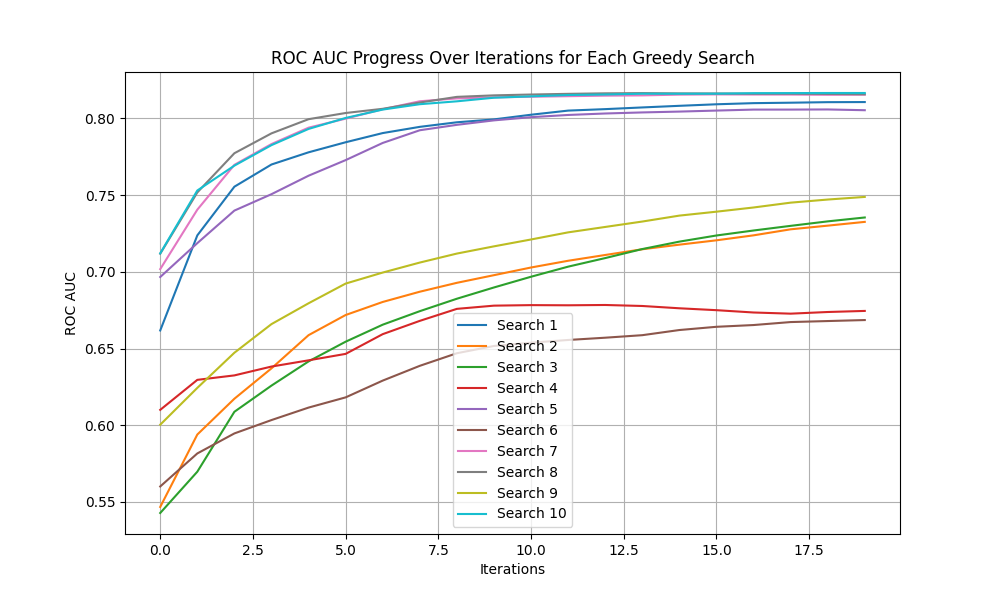

In [24]:
best_aug = uq.perform_greedy_policy_search('savedpolicies', good_idx, bad_idx, num_workers=20, max_iterations=20)

In [25]:
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)

In [26]:
stds_GPS, global_preds_GPS = uq.TTA(transformations, models, eval_all_data_gps, device, usingBetterRandAugment=True, n=n, m=m, bw=True, mean=mean, std=std)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


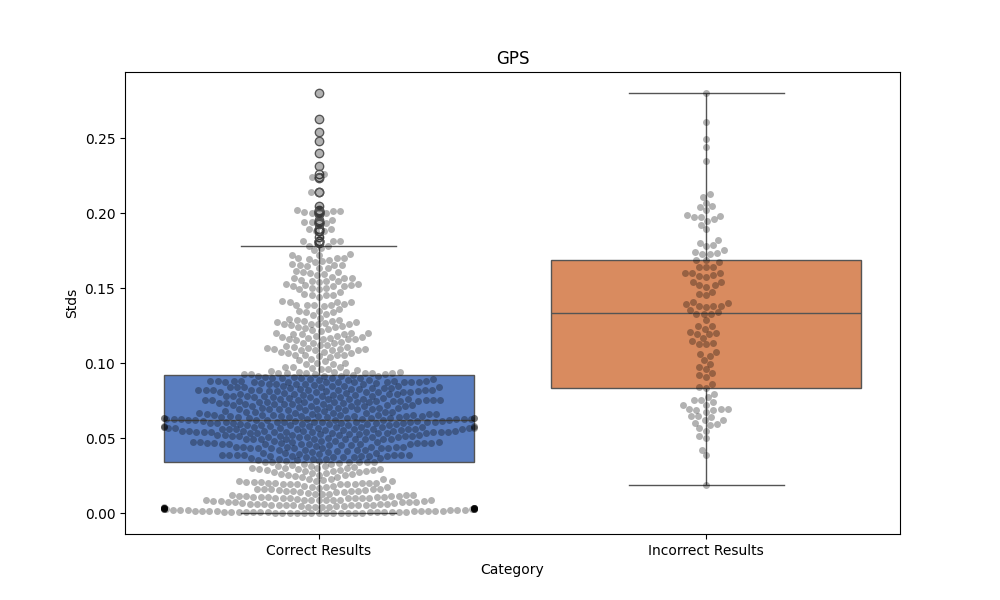

In [27]:
uq.UQ_method_plot([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx], 'Stds', 'GPS')

In [28]:
models_pred = [[all_results[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results))] for i in range(5)]
mean_ensembling_pred = [all_results[k]['mean'] for k in range(len(all_results))]

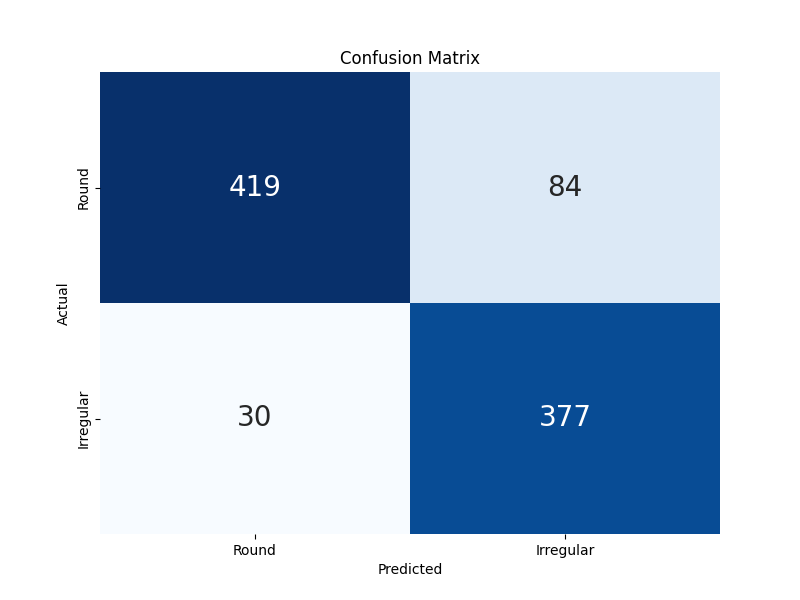

Accuracy: 0.874725 	F1 Score: 0.868664 	ROC AUC: 0.931902 	Specificity: 0.833002 	Sensitivity: 0.926290


In [29]:
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

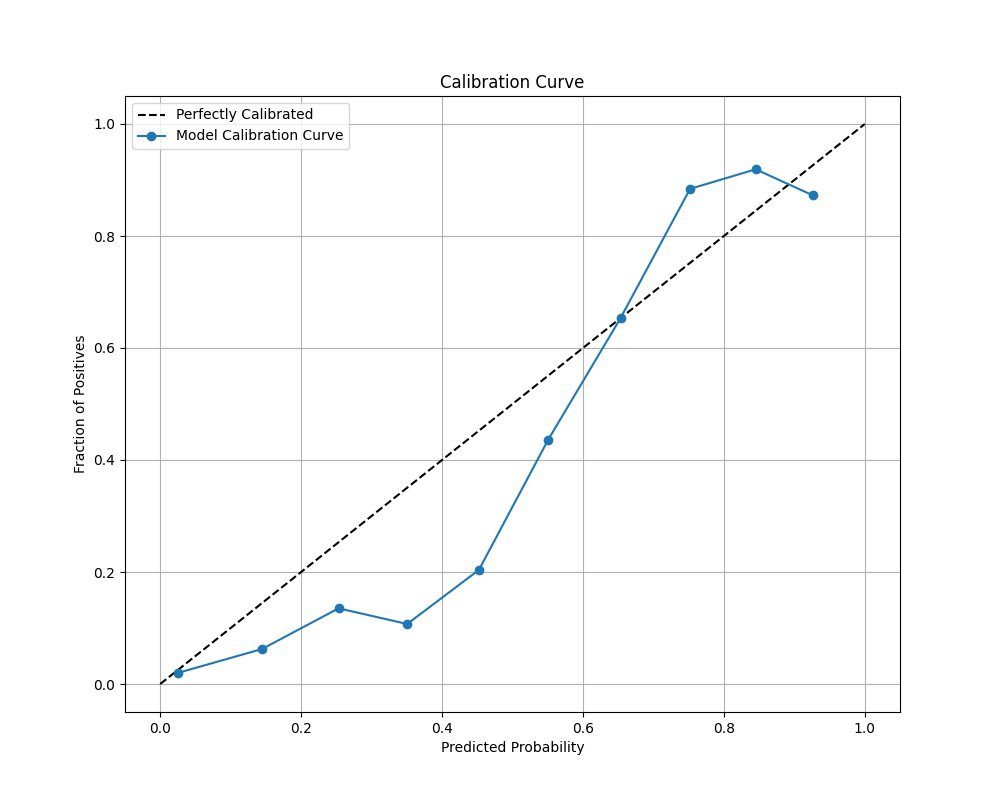

In [30]:
uq.model_calibration_plot(np.array(true_labels), np.array(mean_pred))

In [31]:
stds = uq.ensembling_stds_computation(models_pred)
distances = uq.distance_to_hard_labels_computation(mean_ensembling_pred)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


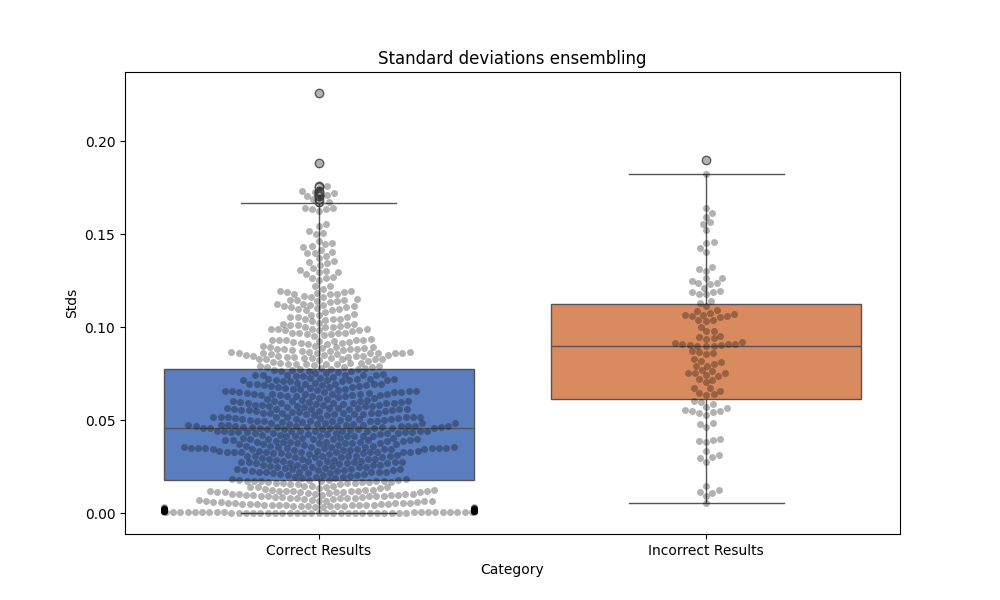

In [32]:
uq.UQ_method_plot([stds[k] for k in good_idx], [stds[j] for j in bad_idx], 'Stds', 'Standard deviations ensembling')

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


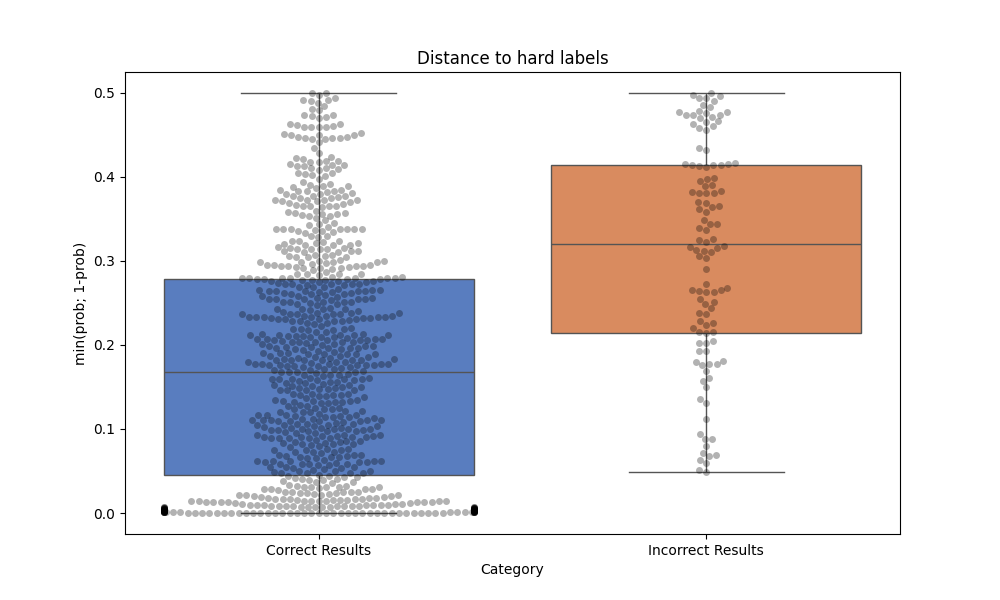

In [33]:
uq.UQ_method_plot([distances[k] for k in good_idx], [distances[j] for j in bad_idx], 'min(prob; 1-prob)', 'Distance to hard labels')

In [34]:
data_without_amb_TTA = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_without_amb_TTA = AxialCutsDataset(data_shape=data_without_amb_TTA, downsample=False)
eval_data_TTA = DataLoader(data_without_amb_TTA, batch_size=128, num_workers=12, shuffle=False)

In [35]:
tta_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandAugment(2, 9),
                    transforms.PILToTensor(),
                    transforms.Lambda(lambda x: x.float()), 
                    transforms.Normalize(mean=mean, std=std)
                ])

In [36]:
stds_tta, global_preds_tta = uq.TTA(tta_transform, models, eval_data_TTA, device, 200)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


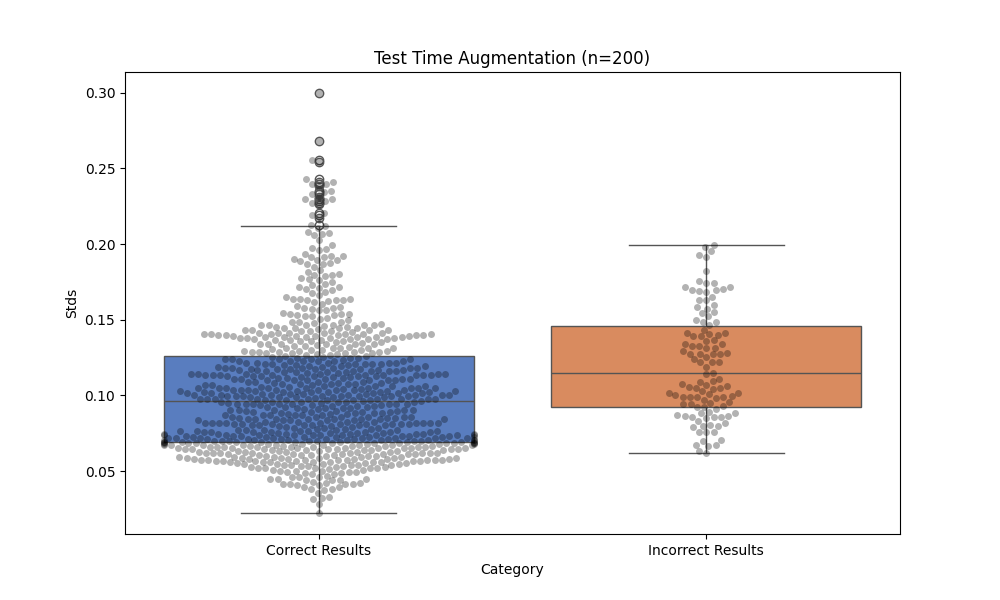

In [37]:
uq.UQ_method_plot([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx], 'Stds', 'Test Time Augmentation (n=200)')

In [38]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds_GPS, stds, distances)))

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


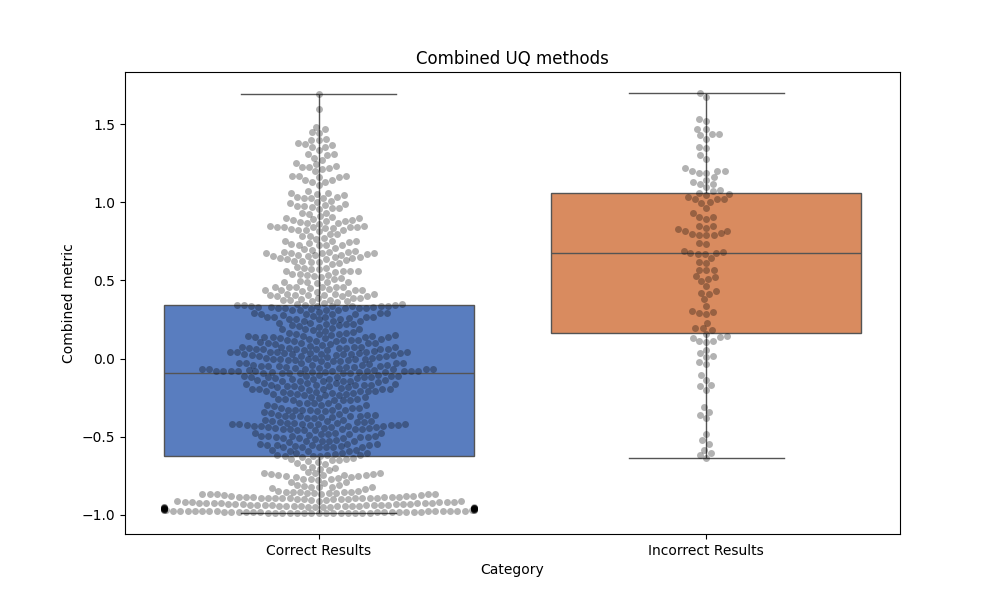

In [39]:
uq.UQ_method_plot([mean_values[k] for k in good_idx], [mean_values[j] for j in bad_idx], 'Combined metric', 'Combined UQ methods')

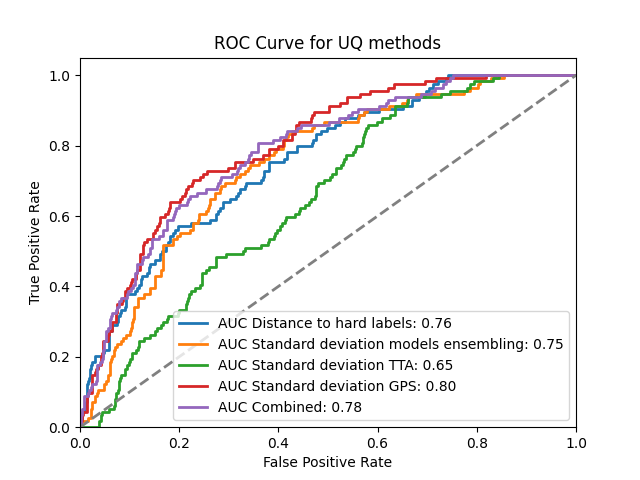

In [40]:
fpr_distance_to_gstd, tpr_distance_to_gstd, auc_distance_to_gstd = uq.roc_curve_UQ_method_computation([distances[k] for k in good_idx], [distances[j] for j in bad_idx])
fpr_std, tpr_std, auc_std = uq.roc_curve_UQ_method_computation([stds[k] for k in good_idx], [stds[j] for j in bad_idx])
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx])
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx])
fpr_combined, tpr_combined, auc_combined = uq.roc_curve_UQ_method_computation([mean_values[k] for k in good_idx], [mean_values[j] for j in bad_idx])

uq.roc_curve_UQ_methods_plot(['Distance to hard labels', 'Standard deviation models ensembling', 'Standard deviation TTA', 'Standard deviation GPS', 'Combined'], [fpr_distance_to_gstd, fpr_std, fpr_std_tta, fpr_std_gps, fpr_combined], [tpr_distance_to_gstd, tpr_std, tpr_std_tta, tpr_std_gps, tpr_combined], [auc_distance_to_gstd, auc_std, auc_std_tta, auc_std_gps, auc_combined])

In [65]:
comb_data = np.column_stack((stds_GPS, stds, distances))
combined = comb_data.flatten()
    
# Compute global mean and standard deviation
global_mean = np.mean(combined)
global_std_dev = np.std(combined)

# Apply z-score standardization to each distribution (column)
standardized_distributions = (comb_data - global_mean) / global_std_dev

In [90]:
def plot_lines_through_points(success, failures, title, xlabel, ylabel, methods):
    """
    Plots lines through points for each row in a 2D numpy array.
    
    Parameters:
    - data_array (numpy.ndarray): 2D array of shape (n_lines, n_points), where each row will be a line plot.
    - x_values (list or array-like, optional): X-values for the points; if None, defaults to sequential integers.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.
    """
    
    cmap_success = cm.Greens
    cmap_failure = cm.Reds
    
    plt.close('all')
    n_lines_success = len(success)
    n_lines_failures = len(failures)

    x_values = range(success[0].shape[0])  # Default x-axis values if not provided
    
    plt.figure(figsize=(10, 6))
    for i in range(n_lines_success):
        plt.plot(x_values, success[i][:], color='g', alpha=0.2)
        
    for j in range(n_lines_failures):
        plt.plot(x_values, failures[j][:], color='r', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(3), methods)
    plt.grid(True)
    plt.show()

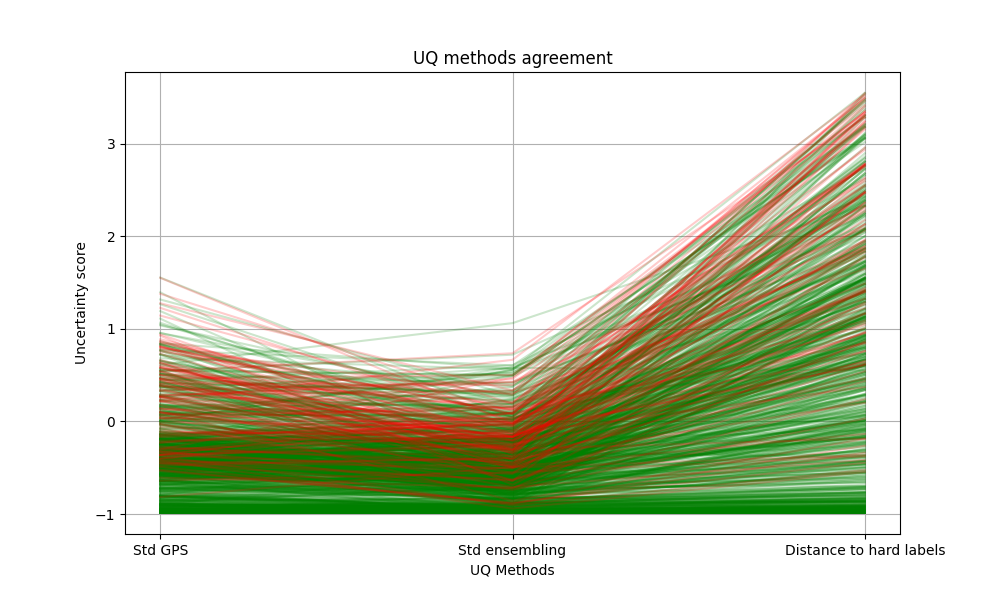

In [91]:
plot_lines_through_points([standardized_distributions[k] for k in good_idx], [standardized_distributions[j] for j in bad_idx], 'UQ methods agreement', 'UQ Methods', 'Uncertainty score', ['Std GPS', 'Std ensembling', 'Distance to hard labels'])

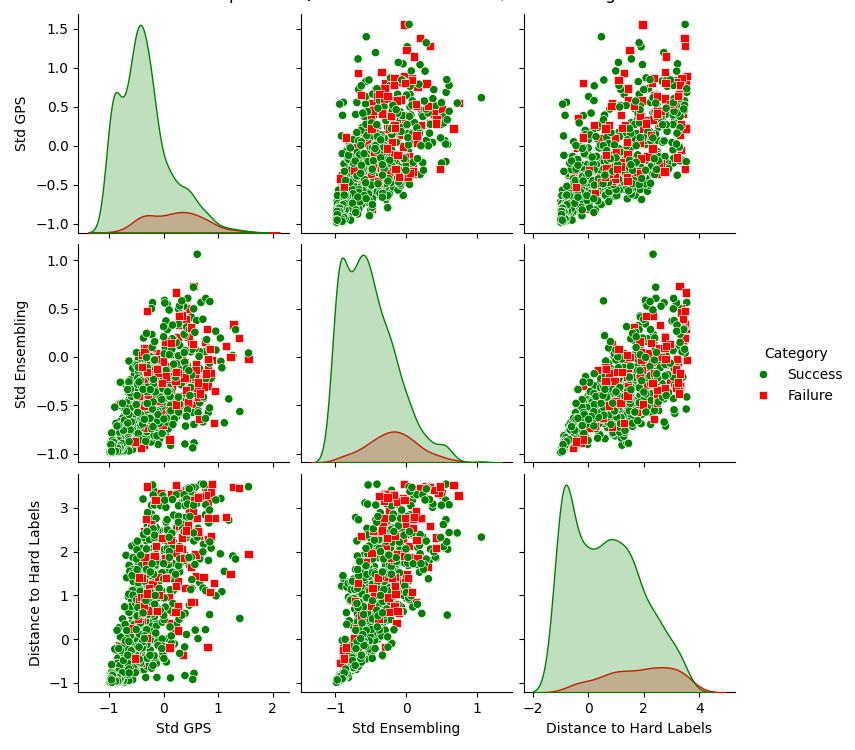

In [99]:
# Step 1: Create a DataFrame from your numpy array
df = pd.DataFrame(standardized_distributions, columns=["Std GPS", "Std Ensembling", "Distance to Hard Labels"])

# Step 2: Add a "Category" column to label each row as "Success" or "Failure"
df['Category'] = 'Success'
df.loc[bad_idx, 'Category'] = 'Failure'

# Step 3: Create a pairplot
sns.pairplot(df, hue="Category", palette={"Success": "green", "Failure": "red"}, diag_kind="kde", markers=["o", "s"])

# Show the plot
plt.suptitle("Pairplot of UQ Methods with Success/Failure Categories", y=1.02)
plt.show()

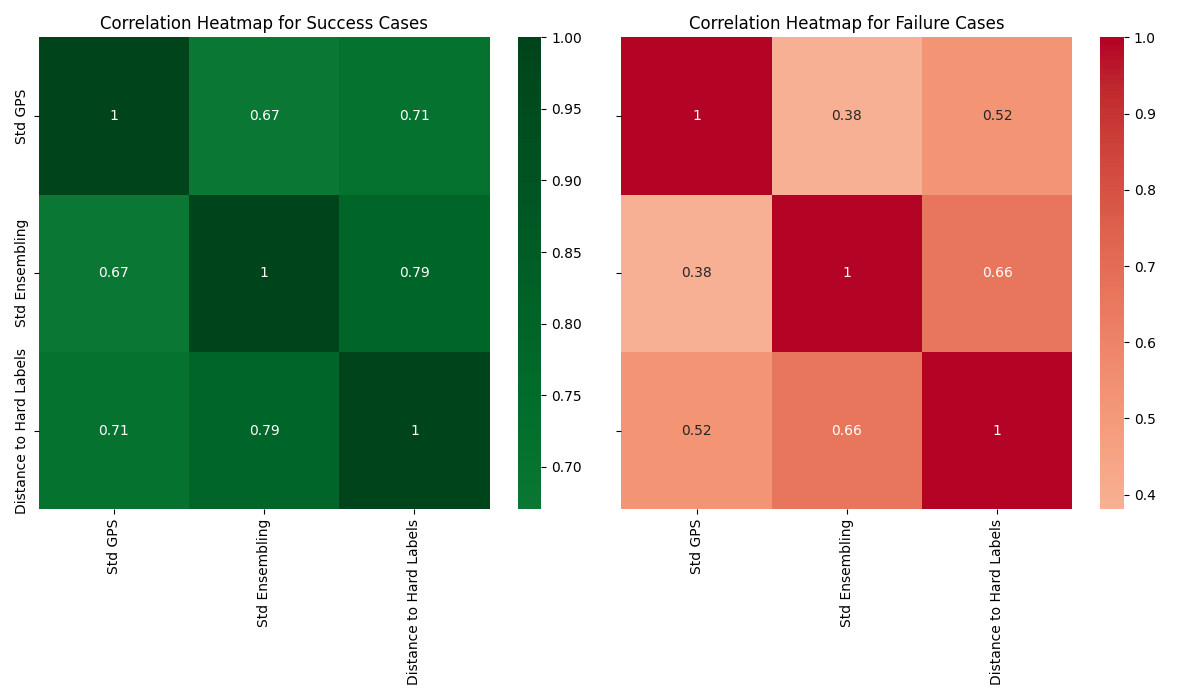

In [113]:
# Step 3: Calculate correlations for Success and Failure cases separately
success_corr = df[df['Category'] == 'Success'].iloc[:, :-1].corr()
failure_corr = df[df['Category'] == 'Failure'].iloc[:, :-1].corr()

# Step 4: Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True)

# Heatmap for Success cases
sns.heatmap(success_corr, annot=True, cmap=cm.Greens, center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap for Success Cases")

# Heatmap for Failure cases
sns.heatmap(failure_corr, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap for Failure Cases")

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(standardized_distributions)

In [93]:
pca.explained_variance_ratio_

array([0.92191314, 0.05531198])

In [94]:
pca_result

array([[-5.13130088e-01,  1.03161815e-02],
       [ 1.68060659e+00,  1.77448645e-01],
       [ 8.42942198e-01,  7.64201243e-01],
       ...,
       [-1.87895854e+00, -1.66959767e-01],
       [ 1.78913817e+00, -1.11172662e-03],
       [-7.53863363e-01,  1.43954043e-01]])

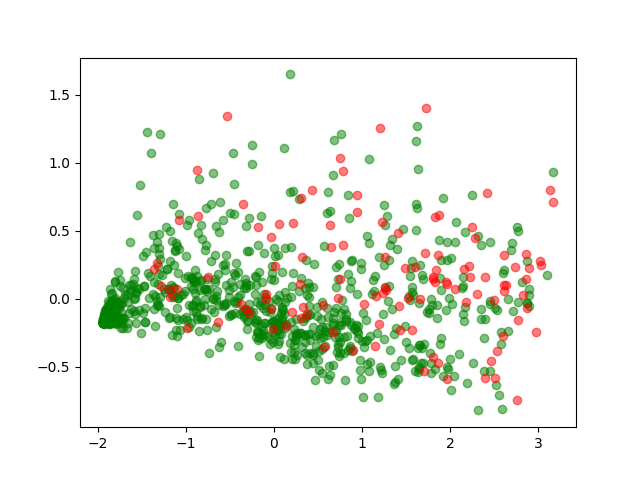

In [98]:
plt.close('all')
plt.scatter(pca_result[good_idx, 0], pca_result[good_idx, 1], color='g', alpha=0.5)
plt.scatter(pca_result[bad_idx, 0], pca_result[bad_idx, 1], color='r', alpha=0.5)

In [ ]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/ThseOzgun-Kappa_OM_CM_DATA_2023-08-12_1625_relFF.csv'

data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')

data_ozgun = dt.fread(path_to_csv_ozgun).to_pandas()
data_ozgun = data_ozgun[['record_id', 'binaire_shape_exp']]#, 'binaire_shape_junior']]

data_ozgun = data_ozgun.replace(True, 'Irregular')
data_ozgun = data_ozgun.replace(False, 'Round')

# Combine col1 and col2 into a new column 'combined' where values are equal, otherwise NaN
#data_ozgun['combined'] = np.where(data_ozgun['binaire_shape_exp'] == data_ozgun['binaire_shape_junior'], data_ozgun['binaire_shape_exp'], np.nan)

# Drop rows where 'combined' is NaN, but keep 'ID' and 'combined' columns
#data_ozgun = data_ozgun[['record_id', 'combined']].dropna()
shape_modified_ozgun = data_ozgun.rename(columns={"record_id": "Record_ID", "binaire_shape_exp": "Shape.1"})

In [ ]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)
axialcuts_dataset = AxialCutsDataset(data_shape=data, downsample=True)

path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified_tr = shape_target_train.replace('Oval', 'Round')
shape_modified_tr.set_index('Record_ID', inplace=True)
list_cases, index = np.unique((pd.DataFrame(axialcuts_dataset.data.index)['ID'].apply(lambda x: x.split('_')[0])), return_index=True)
X = list_cases
y = np.array(shape_modified_tr['Shape.1'])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
images_path_eval_tr = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_training_db'
data_eval_tr = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_eval_tr}/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_eval_tr}/*png')]
        ),
        pd.DataFrame(
            np.zeros(len(glob.glob(f'{images_path_eval_tr}/*png')))
        ),
    ),
    axis=1,
)
data_eval_tr.columns = ['Path', 'ID', 'Shape']
data_eval_tr.set_index('ID', inplace=True)

In [ ]:
results_cv = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    ids_tr = pd.DataFrame(data_eval_tr.index)['ID'].apply(lambda x: x.split('_')[0]).astype('int')
    index_positions = ids_tr[ids_tr[:].isin(np.sort(ids_tr[:].unique())[test_index])].index
    axialcuts_dataset_eval_tr = AxialCutsDataset(data_shape=data_eval_tr.iloc[index_positions], downsample=False, transform=data_transforms)
    eval_all_data_tr = DataLoader(axialcuts_dataset_eval_tr, num_workers=12)
    
    # Store results
    all_results = []
    mean_pred = []
    true_labels = []
    names = []
    model = [models_list[i].to(device)]
    # Inference
    with torch.no_grad():
        for batch in eval_all_data_tr:
            images = batch['image']
            labels = batch['shape']
            img_names = batch['name']
            pred_probs = predict(model, images)
            
            # Collect the results
            mean_pred.append(np.mean(pred_probs))
            true_labels.append(labels.item())
            all_results.append({
                'img_name': img_names[0],
                'true_label': labels.item(),
                'predicted_probabilities': pred_probs,
                'predicted_class': int(np.mean(pred_probs) > 0.5),
                'std': np.std(pred_probs),
                'mean': np.mean(pred_probs)
            })
    results_cv.append(all_results)

In [ ]:
plot_tumor_predictions_with_percentages(results_cv[4], shape_modified)

In [ ]:
cm, bal_acc, sensitivity, specificity = classify_tumors_by_contingent_blocks_with_sorting(results_cv[0], shape_modified)

print("Confusion Matrix:\n", cm)
print("Balanced Accuracy:", bal_acc)
print("Sensitivity (Irregular):", sensitivity)
print("Specificity (Round):", specificity)

In [ ]:
# Store results
all_results_tr = []
mean_pred = []
true_labels = []
names = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_all_data:
        images = batch['image']
        labels = batch['shape']
        img_names = batch['name']
        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results_tr.append({
            'img_name': img_names[0],
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [ ]:
plot_tumor_predictions_with_percentages(all_results_tr, shape_modified)

In [ ]:
cm_tr, bal_acc_tr, sensitivity_tr, specificity_tr = classify_tumors_by_contingent_blocks_with_sorting(all_results_tr, shape_modified)

print("Confusion Matrix:\n", cm_tr)
print("Balanced Accuracy:", bal_acc_tr)
print("Sensitivity (Irregular):", sensitivity_tr)
print("Specificity (Round):", specificity_tr)
display_confusion_matrix(cm_tr)

In [ ]:
images_path_eval_ozgun = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_Ozgun/'
data_eval_ozgun = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_eval_ozgun}/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_eval_ozgun}/*png')]
        ),
        pd.DataFrame(
            np.zeros(len(glob.glob(f'{images_path_eval_ozgun}/*png')))
        ),
    ),
    axis=1,
)
data_eval_ozgun.columns = ['Path', 'ID', 'Shape']
data_eval_ozgun.set_index('ID', inplace=True)


axialcuts_dataset_eval_ozgun = AxialCutsDataset(data_shape=data_eval_ozgun, downsample=False, transform=data_transforms)
eval_all_data_ozgun = DataLoader(axialcuts_dataset_eval_ozgun, num_workers=12)

In [ ]:
# Store results
all_results_oz = []
mean_pred = []
true_labels = []
names = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_all_data_ozgun:
        images = batch['image']
        labels = batch['shape']
        img_names = batch['name']
        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results_oz.append({
            'img_name': img_names[0],
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [ ]:
plot_tumor_predictions_with_percentages(all_results_oz, shape_modified_ozgun)

In [ ]:
cm_oz, bal_acc_oz, sensitivity_oz, specificity_oz = classify_tumors_by_contingent_blocks_with_sorting(all_results_oz, shape_modified_ozgun)

print("Confusion Matrix:\n", cm_oz)
print("Balanced Accuracy:", bal_acc_oz)
print("Sensitivity (Irregular):", sensitivity_oz)
print("Specificity (Round):", specificity_oz)
display_confusion_matrix(cm_oz)

In [ ]:
cm, bal_acc, sensitivity, specificity = classify_tumors_by_contingent_blocks_with_sorting(all_results_tr + all_results_oz, pd.concat((shape_modified, shape_modified_ozgun)))

print("Confusion Matrix:\n", cm)
print("Balanced Accuracy:", bal_acc)
print("Sensitivity (Irregular):", sensitivity)
print("Specificity (Round):", specificity)
display_confusion_matrix(cm)

In [ ]:
all_results_tr